In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout, Flatten, Input, Reshape
from keras.callbacks import EarlyStopping
from scipy.optimize import newton
from scipy.integrate import odeint 
from math import *
import time
import random

2024-10-29 21:53:42.920322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 21:53:42.930089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 21:53:42.941180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 21:53:42.944415: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 21:53:42.952787: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.config.list_physical_devices()

2024-08-04 18:13:36.250377: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-04 18:13:36.273667: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-04 18:13:36.273788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#xy0 is [x0,y0] vxy0 is [vx0, vy0]
def projectile_motion(g, mu, xy0, vxy0, tt):
    # use a four-dimensional vector function vec = [x, y, vx, vy]
    def dif(vec, t):
        # time derivative of the whole vector vec
        v = sqrt(vec[2] ** 2 + vec[3] ** 2)
        return [vec[2], vec[3], -mu * v * vec[2], -g - mu * v * vec[3]]

    # solve the differential equation numerically
    vec = odeint(dif, [xy0[0], xy0[1], vxy0[0], vxy0[1]], tt)
    return vec[:, 0], vec[:, 1], vec[:, 2], vec[:, 3]  # return x, y, vx, vy

def makepath(angle, vel):
    alpha0 = radians(angle)
    xy = [0.0, 0.0]
    vxy =[vel * cos(alpha0), vel* sin(alpha0)]
    #use newton to find the zero of the function for the y component of the velocity [3][1] starting from 0
    T_peak = newton(lambda t: projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), [0, t])[3][1], 0)
    y_peak = projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), [0, T_peak])[1][1]
    #use newton to find the zero of the y position starting from 2*T_peak
    T = newton(lambda t: projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), [0, t])[1][1], 2 * T_peak)
    #print(T, 2*T_peak)
    t = np.linspace(0, T, 101)
    x, y, vx, vy = projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), t)
    return x, y, t

# Parameters of projectile (modelled after a baseball)
g       = 9.81         # Acceleration due to gravity (m/s^2)
rho_air = 1.29         # Air density (kg/m^3)
v0      = 44.7         # Initial velocity (m/s)
alpha0  = radians(75)  # Launch angle (deg.)
m       = 0.145        # Mass of projectile (kg)
cD      = 0.5          # Drag coefficient (spherical projectile)
r       = 0.0366       # Radius of projectile (m)
mu = 0.5 * cD * (pi * r ** 2) * rho_air / m

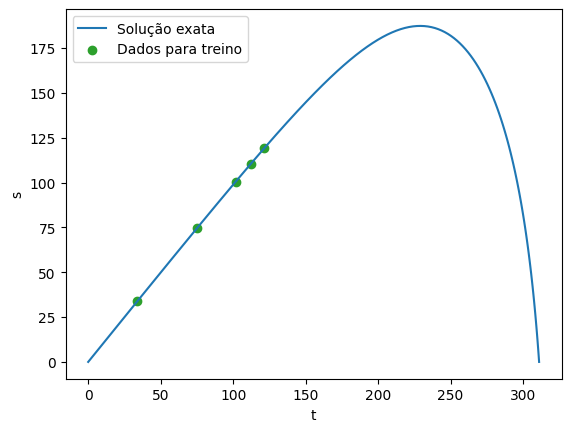

In [20]:
angulo0,velocidade0 = 45,500
indices = random.sample(range(1,10), 5)
X,Y,T = makepath(angulo0,velocidade0)
X = tf.convert_to_tensor(X,dtype='float32')
X = tf.expand_dims(X, 1)
Y = tf.convert_to_tensor(Y,dtype='float32')
Y = tf.expand_dims(Y, 1)
T = tf.convert_to_tensor(T,dtype='float32')
T = tf.expand_dims(T, 1)
Traj = tf.concat([X,Y],axis=1)
x_data = tf.gather(T,indices)
y_data = tf.gather(Traj,indices)
plt.figure()
plt.plot(X, Y, label="Solução exata")
plt.scatter(y_data[:,0],y_data[:,1], color="tab:green", label="Dados para treino")
plt.xlabel('t')
plt.ylabel('s')
plt.legend()
plt.show()

In [21]:
# x da EDO, com 30 pontos
x_phys = tf.linspace(0,15,150)
x_phys = tf.cast(x_phys, tf.float64)
x_phys = tf.expand_dims(x_phys, 1)

#hiperparametros
tf.random.set_seed(5) #fixa a semente para cada teste ser igual
learning_rate = 0.0005
epochs = 100000 #uns 780 seg no colab
k_phy_loss1=(1e1) # coloque zero nesta grandeza para uma FF!
k_phy_loss2=(1e1)
k_phy_loss3 = (1e1)

# Arquiteruta do modelo neural, usando o keras
input_dim = 1
hidden_dim = 64
hidden_dim2 = 64
output_dim = 2

model_keras=tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_dim, input_dim=input_dim, use_bias=1,activation='tanh'),
    tf.keras.layers.Dense(hidden_dim2, activation='tanh'),
    tf.keras.layers.Dense(output_dim, activation='linear')
],name='rede_para_PINN')
model_keras.summary()

Model: "rede_para_PINN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,418 (17.26 KB)

 Trainable params: 4,418 (17.26 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Para testar só mse
model_keras.compile(optimizer="adam",loss="mse")
model_keras.fit(x_data,y_data,epochs=1,verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step - loss: 8798.6846


In [24]:
optimizer = tf.optimizers.Adam(learning_rate=0.0005)
@tf.function
def training_step(x_data,y_data):
    batch_X = x_data
    batch_y = tf.convert_to_tensor(y_data, dtype='float32')
    with tf.GradientTape() as tape:
        yh = model_keras(batch_X) #calcula as saidas da rede nos pontos "experimentais"
        data_loss = tf.reduce_mean(tf.square(yh - batch_y))
        with tf.GradientTape() as t2:
            t2.watch(x_phys)
            with tf.GradientTape() as t1:
                t1.watch(x_phys)
                yhp = model_keras(x_phys) #calcula as saidas da rede nos pontos escolhidos para ajustar a EDO
            dx  = tf.reshape(t1.batch_jacobian(yhp, x_phys),(-1,2)) # calcula dy/dx que é igual a ds/dt
        dx2 = tf.reshape(t2.batch_jacobian(dx, x_phys),(-1,2)) # calcula d^2y/dx^2 que é igual a d^2s/dt^2
        vx = dx[:,0]
        vy = dx[:,1]
        dvx = dx2[:,0]
        dvy = dx2[:,1]
        V = tf.sqrt(tf.square(vx)+tf.square(vy))        
        physics1 = tf.cast(tf.reduce_mean(tf.square(dvx+mu*vx*V)),"float32")
        physics2 = tf.cast(tf.reduce_mean(tf.square(dvy+g+mu*vy*V)),"float32")
        physics3 =  tf.cast(tf.reduce_mean(tf.square(yhp[0,0])),"float32")
        physics4 =  tf.cast(tf.reduce_mean(tf.square(yhp[0,1])),"float32")
        Phys_loss1 = k_phy_loss1*physics1
        Phys_loss2 = k_phy_loss2*physics2 
        Phys_loss3 = k_phy_loss3*physics3
        Phys_loss4 = k_phy_loss3*physics4
        
        data_loss = tf.cast(data_loss, "float32")
        loss = Phys_loss1 + Phys_loss2 + Phys_loss3 + Phys_loss4 + data_loss
    gradients = tape.gradient(loss, model_keras.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_keras.trainable_variables))

    return Phys_loss1 + Phys_loss2, Phys_loss3+Phys_loss4, data_loss, loss


In [25]:
start_time = time.time()
h_loss=[]
h_data_loss=[]
h_Phys_loss=[]
for epoch in range(epochs):
    loss = training_step(x_data,y_data)
    l1,l2,l3,l4 = loss
    h_loss.append(l4)
    h_data_loss.append(l3)
    h_Phys_loss.append(l1+l2)
    if ((epoch+1)%500==0):
      print(f"Epoch {epoch + 1}/{epochs}, Loss: {l4}, Data Loss: {l3}, Physics Loss: {l1+l2}")
    if l4<=1e-4:
       break
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 500/100000, Loss: 7436.71826171875, Data Loss: 6188.9912109375, Physics Loss: 1247.7269287109375
Epoch 1000/100000, Loss: 6449.97216796875, Data Loss: 5072.0078125, Physics Loss: 1377.9644775390625
Epoch 1500/100000, Loss: 5599.58154296875, Data Loss: 4131.10400390625, Physics Loss: 1468.4775390625
Epoch 2000/100000, Loss: 4822.58154296875, Data Loss: 3311.43603515625, Physics Loss: 1511.1453857421875
Epoch 2500/100000, Loss: 4094.952880859375, Data Loss: 2582.041748046875, Physics Loss: 1512.9110107421875
Epoch 3000/100000, Loss: 3426.330322265625, Data Loss: 1946.1927490234375, Physics Loss: 1480.1376953125
Epoch 3500/100000, Loss: 2832.17431640625, Data Loss: 1415.776123046875, Physics Loss: 1416.3980712890625
Epoch 4000/100000, Loss: 2323.4765625, Data Loss: 991.6110229492188, Physics Loss: 1331.865478515625
Epoch 4500/100000, Loss: 1904.7923583984375, Data Loss: 668.3104248046875, Physics Loss: 1236.4820556640625
Epoch 5000/100000, Loss: 1572.011474609375, Data Loss: 433.944

KeyboardInterrupt: 

Text(0, 0.5, 'loss')

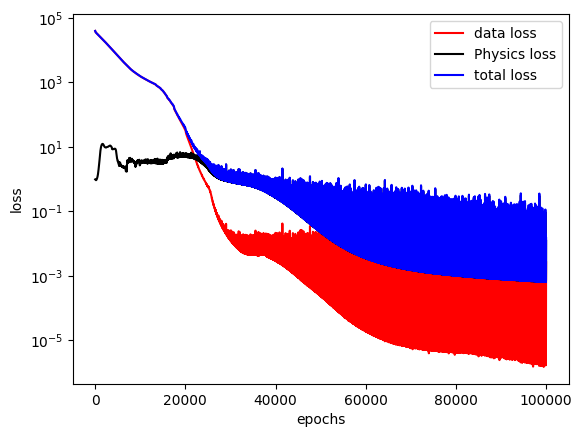

In [8]:
plt.figure()
plt.plot(h_data_loss,'r',label='data loss');
plt.plot(h_Phys_loss,'k',label='Physics loss');
plt.plot(h_loss,'b',label='total loss');
plt.yscale('log')
plt.legend()
plt.xlabel('epochs');plt.ylabel('loss')



In [26]:
prev = np.array(model_keras.predict(T)).reshape(-1,2)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x704a09b8eef0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


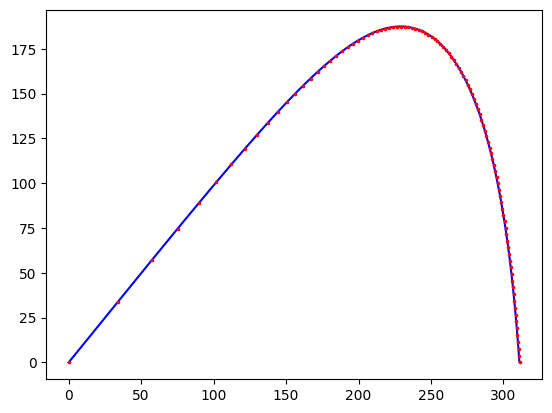

In [27]:
plt.plot(prev[:,0],prev[:,1],"b-",markersize=1.6)
#plt.plot(y_data[:,0],y_data[:,1],"ro")
plt.plot(X,Y,"ro",markersize=1.6)